# Анализ бизнес-показателей

У нас в распоряжении есть лог сервера с данными о посещениях приложения Procrastinate Pro+ новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. 

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Наша задача — разобраться в причинах и помочь компании выйти в плюс.

Нам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.

## Изучение данных 

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', 30)
pd.set_option("display.float_format", "{:.3f}".format)

In [2]:
# чтение файла с данными и сохранение в переменные
visits, orders, costs = (
    pd.read_csv('../../yandex-praktikum-sources/ads_visits.csv'),  # посещения
    pd.read_csv('../../yandex-praktikum-sources/ads_orders.csv'),  # заказы
    pd.read_csv('../../yandex-praktikum-sources/ads_costs.csv'),  # траты на рекламу
)

In [3]:
# просмотр информации о таблицах и проверка наличия дубликатов
for i in [visits, orders, costs]:
    display(i.head())
    display(i.info())
    print(i.duplicated().sum())

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

0


User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52    4.990
1  174361394180  2019-05-01 12:24:04    4.990
2  529610067795  2019-05-01 11:34:04    4.990
3  319939546352  2019-05-01 15:34:40    4.990
4  366000285810  2019-05-01 13:59:51    4.990

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

0


dt   Channel   costs
0  2019-05-01  FaceBoom 113.300
1  2019-05-02  FaceBoom  78.100
2  2019-05-03  FaceBoom  85.800
3  2019-05-04  FaceBoom 136.400
4  2019-05-05  FaceBoom 122.100

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

0


Согласно документации к данным:
1. Таблица `visits_log_short` (лог сервера с информацией о посещениях сайта):

- `User Id` — уникальный идентификатор пользователя
- `Device` — категория устройства пользователя
- `Session start` — дата и время начала сессии
- `Session End` — дата и время окончания сессии
- `Channel` — идентификатор рекламного источника, из которого пришел пользователь
- `Region` - страна пользователя

2. Таблица `orders_log_short` (информация о заказах):

- `User Id` — уникальный id пользователя, который сделал заказ
- `Event Dt` — дата и время покупки
- `Revenue` — выручка

3. Таблица `costs_short` (информация о затратах на маркетинг):

- `Channel` — идентификатор рекламного источника
- `Dt` — дата
- `Costs` — затраты на этот рекламный источник в этот день

Пропусков в данных нет, но названия столбцов не соответствуют snake case. Исправим это.

In [4]:
# приведение имен столбцов к snake_case
for i in [visits, orders, costs]:
    i.columns = [x.lower().replace(' ', '_') for x in i.columns.values]

Данные о времени приведем к соответствующему типу данных.

In [5]:
# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [6]:
# проверим, что получилось
for i in [visits, orders, costs]:
    display(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

Данные к анализу подготовлены.

## Функции для расчета и анализа LTV, ROI, удержания и конверсии

Введем функции, созданные ранее.

### Функция для создания пользовательских профилей

In [7]:
def get_profiles(sessions, orders, costs):
    # находим параметры первых посещений
    profiles = (sessions.sort_values(by=['user_id', 'session_start'])
                .groupby('user_id')
                .agg(
                    {
                        'session_start' : 'first',
                        'channel' : 'first',
                        'device' : 'first',
                        'region' : 'first'
                    }
                )
                .rename(columns={'session_start' : 'first_ts'})
                .reset_index()
               )
    
    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # добавляем признак пользователей, совершивших покупку
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    
    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')
    
    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    
    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles

### Функция для расчета удержания

In [8]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions
    
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw  = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days
    
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для расчета конверсии

In [9]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

### Функция для расчета LTV и ROI

In [10]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

### Функция для сглаживания фрейма

In [11]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

### Функция для визуализации удержания

In [12]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

### Функция для визуализации конверсии

In [13]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Функция для визуализации LTV и ROI

In [14]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Исследовательский анализ данных

### Профили пользователей
Построим профили пользователей с использованием введенной функции. Определим минимальную и максимальную дату привлечения пользователей.

In [15]:
profiles = get_profiles(visits, orders, costs)
display(profiles.head())

user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True             1.088  
1  2019-07-09 2019-07-01  False             1.107  
2  2019-10-01 2019-10-01  False             0.000  
3  2019-08-22 2019-08-01  False             0.988  
4  2019-10-02 2019-10-01  False             0.231

In [16]:
print(f'Минимальная дата привлечения пользователей {profiles.first_ts.min()}, максимальная {profiles.first_ts.max()}')

Минимальная дата привлечения пользователей 2019-05-01 00:00:41, максимальная 2019-10-27 23:59:04


В логе данные о новых пользователях, пришедших с 1 мая по 27 октября 2019 года. В нашем исследовании мы принимаем за горизонт анализа 2 недели, а за точку наблюдения - 1 ноября.

In [17]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа

Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

### Распределение пользователей по странам

In [18]:
# из каких стран приходят пользователи?
print(profiles.region.unique())

['United States' 'France' 'Germany' 'UK']


In [19]:
# Какие страны дают больше всего платящих пользователей?
# в какой стране доля покупателей среди пользователей наибольшая?
region_users = (
    profiles.groupby('region')['user_id'].nunique().reset_index()
    .merge(profiles[profiles['payer']==True].groupby('region')['user_id'].nunique().reset_index(), 
           on = 'region', how = 'left')
)
region_users.set_axis(['region', 'total_users', 'payers'], axis='columns', inplace=True)
region_users['payer_rate'] = region_users.payers / region_users.total_users
display(region_users.sort_values(by='payer_rate', ascending=False))

region  total_users  payers  payer_rate
3  United States       100002    6902       0.069
1        Germany        14981     616       0.041
2             UK        17575     700       0.040
0         France        17450     663       0.038

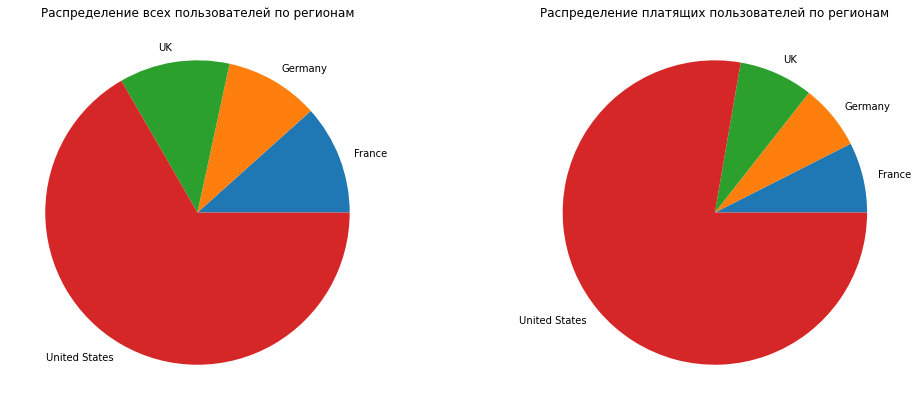

In [20]:
# построим графики об этом
fig, ax = plt.subplots(1, 2, figsize = (17, 7),  squeeze=False)
ax[0][1].pie(region_users.payers, labels=region_users.region)
ax[0][1].set(title='Распределение платящих пользователей по регионам')
ax[0][0].pie(region_users.total_users, labels=region_users.region)
ax[0][0].set(title='Распределение всех пользователей по регионам')
plt.show()

Три четверти пользователей - жители США, четверть - из Европы. 

Доля платящих пользователей среди жителей США самая высокая - почти 7%, в странах Европы около 4%.

### Распределение пользователей по устройствам

In [21]:
# Какими устройствами пользуются?
print(profiles.device.unique())

['Mac' 'iPhone' 'PC' 'Android']


In [22]:
# С каких устройств чаще всего заходят платящие пользователи?
device_users = (
    profiles.groupby('device')['user_id'].nunique().reset_index()
    .merge(profiles[profiles['payer']==True].groupby('device')['user_id'].nunique().reset_index(), on = 'device', how = 'left')
)
device_users.set_axis(['device', 'total_users', 'payers'], axis='columns', inplace=True)
device_users['payer_rate'] = device_users.payers / device_users.total_users
device_users.sort_values(by='payer_rate', ascending=False)

device  total_users  payers  payer_rate
1      Mac        30042    1912       0.064
3   iPhone        54479    3382       0.062
0  Android        35032    2050       0.059
2       PC        30455    1537       0.050

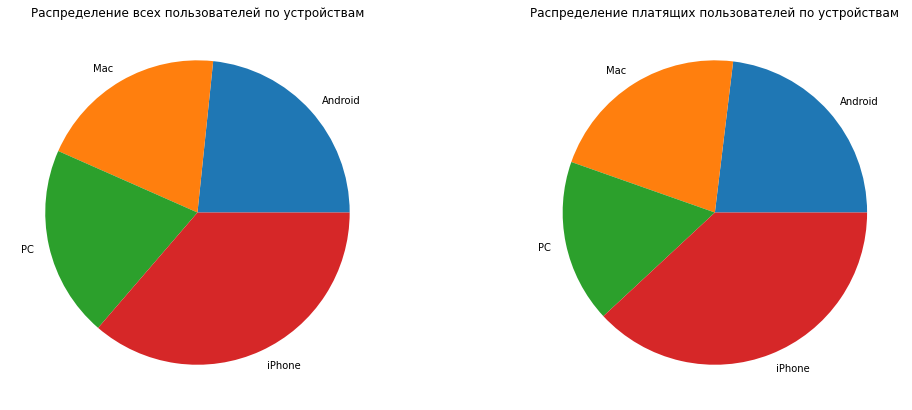

In [23]:
# построим график об этом
fig, ax = plt.subplots(1, 2, figsize = (17, 7),  squeeze=False)
ax[0][0].pie(device_users.total_users, labels=device_users.device)
ax[0][0].set(title='Распределение всех пользователей по устройствам')
ax[0][1].pie(device_users.payers, labels=device_users.device)
ax[0][1].set(title='Распределение платящих пользователей по устройствам')
plt.show()


Среди пользователей как платящих, так и нет, больше всего владельцев iPhone, а доля платящих выше всего среди владельцев Mac. 

Проверим, нет ли у жителей разных стран любимых платформ.

In [24]:
reg_dev = profiles.pivot_table(index='device', columns='region', values='user_id', aggfunc='nunique').reset_index()
reg_dev

region   device  France  Germany    UK  United States
0       Android    5252     4440  5141          20199
1           Mac    1838     1584  1778          24842
2            PC    6940     5945  7138          10432
3        iPhone    3420     3012  3518          44529

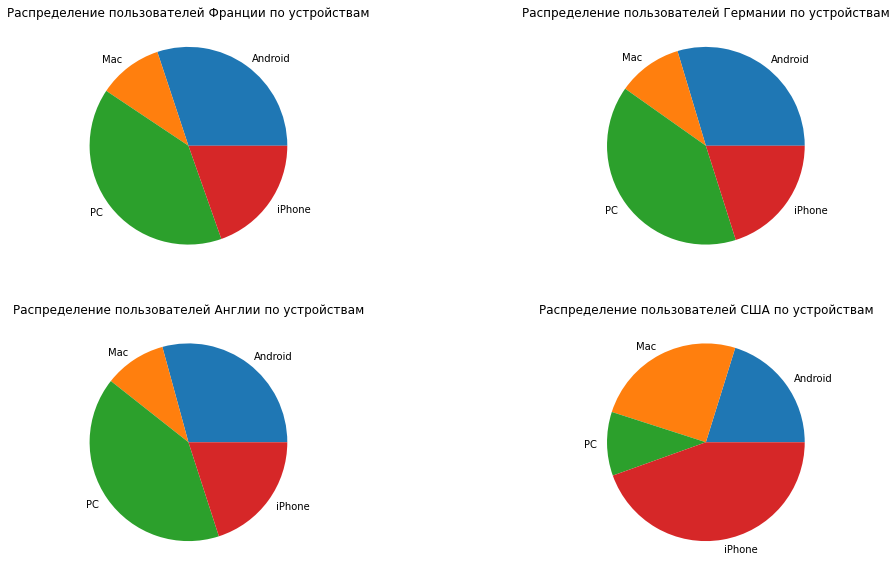

In [25]:
fig, ax = plt.subplots(2, 2, figsize = (17, 10),  squeeze=False)
ax[0][0].pie(reg_dev['France'], labels=reg_dev.device)
ax[0][0].set(title='Распределение пользователей Франции по устройствам')
ax[0][1].pie(reg_dev['Germany'], labels=reg_dev.device)
ax[0][1].set(title='Распределение пользователей Германии по устройствам')
ax[1][0].pie(reg_dev['UK'], labels=reg_dev.device)
ax[1][0].set(title='Распределение пользователей Англии по устройствам')
ax[1][1].pie(reg_dev['United States'], labels=reg_dev.device)
ax[1][1].set(title='Распределение пользователей США по устройствам')
plt.show()

В странах Европы большая часть пользователей - обладатели PC и Android, а в США - iPhone и Mac популярнее всего.

С учетом того, как много пользователей приложения из США, перекос среди популярных платформ легко объяснить.

### Распределение пользователей по рекламным каналам

In [26]:
# По каким рекламным каналам шло привлечение пользователей?
print(profiles.channel.unique())

['FaceBoom' 'organic' 'AdNonSense' 'YRabbit' 'MediaTornado'
 'RocketSuperAds' 'LeapBob' 'TipTop' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']


In [27]:
# Какие каналы приносят больше всего платящих пользователей?
ch_users = (
    profiles.groupby('channel')['user_id'].nunique().reset_index()
    .merge(profiles[profiles['payer']==True].groupby('channel')['user_id'].nunique().reset_index(), on = 'channel', how = 'left')
)
ch_users.set_axis(['channel', 'total_users', 'payers'], axis='columns', inplace=True)
ch_users['payer_rate'] = ch_users.payers / ch_users.total_users
ch_users.sort_values(by='payer_rate', ascending=False)

channel  total_users  payers  payer_rate
1             FaceBoom        29144    3557       0.122
0           AdNonSense         3880     440       0.113
9       lambdaMediaAds         2149     225       0.105
6               TipTop        19561    1878       0.096
5       RocketSuperAds         4448     352       0.079
7       WahooNetBanner         8553     453       0.053
8              YRabbit         4312     165       0.038
3         MediaTornado         4364     156       0.036
2              LeapBob         8553     262       0.031
4   OppleCreativeMedia         8605     233       0.027
10             organic        56439    1160       0.021

In [28]:
# Как связаны страны и каналы привлечения?
region_channels = (
    profiles[profiles['payer']==True].pivot_table(index='channel', 
                                              columns = 'region', 
                                              values = 'user_id', 
                                              aggfunc='count')
    .reset_index()
    .sort_values('United States')
    .query('channel != "organic"')
)
region_channels

region             channel  France  Germany      UK  United States
3             MediaTornado     NaN      NaN     NaN        156.000
8                  YRabbit     NaN      NaN     NaN        165.000
5           RocketSuperAds     NaN      NaN     NaN        352.000
6                   TipTop     NaN      NaN     NaN       1878.000
1                 FaceBoom     NaN      NaN     NaN       3557.000
0               AdNonSense 150.000  142.000 148.000            NaN
2                  LeapBob  90.000   69.000 103.000            NaN
4       OppleCreativeMedia  80.000   64.000  89.000            NaN
7           WahooNetBanner 152.000  148.000 153.000            NaN
9           lambdaMediaAds  82.000   67.000  76.000            NaN

Оказывается, рекламные каналы для США и Европы вообще не пересекаются (кроме "органиков"). Создадим для последующего анализа списки европейских и американских каналов.

In [29]:
# сохраним списки каналов для США и Европы
usa_channels = region_channels.loc[region_channels['United States'] > 0,'channel']
eu_channels = region_channels.loc[region_channels['UK'] > 0,'channel']

In [30]:
ch_users.query('channel in @usa_channels').sort_values(by='payer_rate', ascending=False)

channel  total_users  payers  payer_rate
1        FaceBoom        29144    3557       0.122
6          TipTop        19561    1878       0.096
5  RocketSuperAds         4448     352       0.079
8         YRabbit         4312     165       0.038
3    MediaTornado         4364     156       0.036

In [31]:
ch_users.query('channel in @eu_channels').sort_values(by='payer_rate', ascending=False)

channel  total_users  payers  payer_rate
0          AdNonSense         3880     440       0.113
9      lambdaMediaAds         2149     225       0.105
7      WahooNetBanner         8553     453       0.053
2             LeapBob         8553     262       0.031
4  OppleCreativeMedia         8605     233       0.027

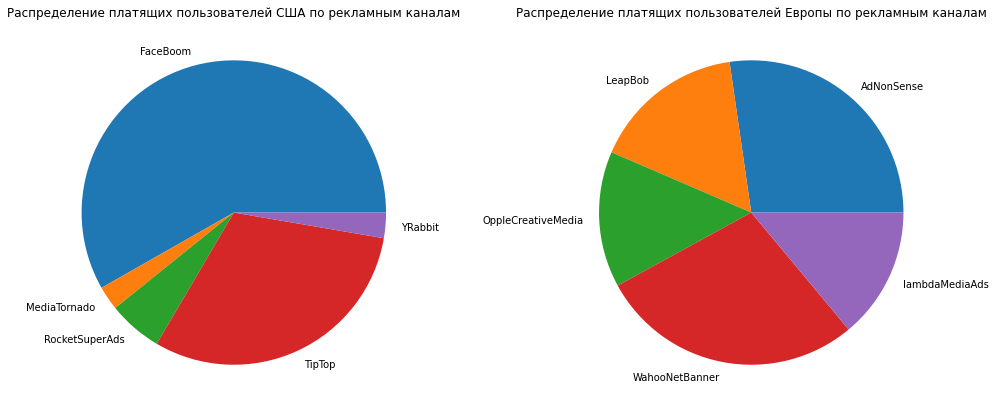

In [32]:
# построим график об этом
fig, ax = plt.subplots(1, 2, figsize = (17, 7),  squeeze=False)
ax[0][0].pie(ch_users.query('channel in @usa_channels')['payers'], labels=ch_users.query('channel in @usa_channels')['channel'])
ax[0][0].set(title='Распределение платящих пользователей США по рекламным каналам')
ax[0][1].pie(ch_users.query('channel in @eu_channels')['payers'], labels=ch_users.query('channel in @eu_channels')['channel'])
ax[0][1].set(title='Распределение платящих пользователей Европы по рекламным каналам')
plt.show()

### Выводы

- Всего в наших данных информация о пользователях из четырех стран - США, Франции, Германии и Соединенного Королевства. 

- Подавляющее количество пользователей в США. Доли платящих пользователей не столь отличаются от страны к стране, так что и количество покупателей также наибольшее в США.

- Приложением пользуются на 4 платформах - Mac, PC, iPhone и Android. Больше всего пользователей с айфонами, но платят немного чаще пользователи Mac. При этом "яблоки" более популярны в США, а жители Европы чаще используют PC и Android.  

- Всего рекламных каналов, по которым приходят пользователи, 11, включая "органиков", причем рекламные каналы четко разделены - 5 только для США и 5 - для европейских стран. 

- Среди площадок американского рынка максимальное количество покупателей привлекают площадки FaceBoom и TipTop - подавляющее количество покупателей из США пришли именно оттуда. В Европе такого гигантского неравенства нет. Там больше всего покупателей привлекла сеть WahooNetBanner, однако доля покупателей среди привлеченных пользователей невысокая.

## Анализ маркетинга

### Общие затраты на рекламу

Выясним:
- Сколько денег потратили на привлечение всего?
- Сколько денег потрачено на каждый из источников и сколько удалось привлечь покупателей?
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [33]:
# Сколько денег потратили всего?
costs.costs.sum()

105497.30000000002

In [34]:
# Сколько денег потратили на каждый источник?
costs.groupby('channel')['costs'].sum().sort_values(ascending=False).reset_index()

channel     costs
0              TipTop 54751.300
1            FaceBoom 32445.600
2      WahooNetBanner  5151.000
3          AdNonSense  3911.250
4  OppleCreativeMedia  2151.250
5      RocketSuperAds  1833.000
6             LeapBob  1797.600
7      lambdaMediaAds  1557.600
8        MediaTornado   954.480
9             YRabbit   944.220

In [35]:
# сколько покупателей пришло из каждого канала
ch_users.query('channel != "organic"')[['channel', 'payers']].sort_values(by='payers', ascending=False)

channel  payers
1            FaceBoom    3557
6              TipTop    1878
7      WahooNetBanner     453
0          AdNonSense     440
5      RocketSuperAds     352
2             LeapBob     262
4  OppleCreativeMedia     233
9      lambdaMediaAds     225
8             YRabbit     165
3        MediaTornado     156

In [36]:
# сколько в среднем стоило привлечение покупателей
# собираем таблицу
ad_costs = ch_users.merge(costs.groupby('channel')['costs'].sum().reset_index(), on = 'channel', how = 'left')
ad_costs = ad_costs.query('channel != "organic"')
# считаем среднее
ad_costs['avg_costs'] = ad_costs.costs / ad_costs.payers
ad_costs['acq_costs'] = ad_costs.costs / ad_costs.total_users
ad_costs.loc[ad_costs['channel'].isin(usa_channels), 'region'] = 'USA'
ad_costs.loc[ad_costs['channel'].isin(eu_channels), 'region'] = 'EU'
# сортируем по среднему
ad_costs.sort_values(by='avg_costs', ascending=False)


channel  total_users  payers  payer_rate     costs  avg_costs  \
6              TipTop        19561    1878       0.096 54751.300     29.154   
7      WahooNetBanner         8553     453       0.053  5151.000     11.371   
4  OppleCreativeMedia         8605     233       0.027  2151.250      9.233   
1            FaceBoom        29144    3557       0.122 32445.600      9.122   
0          AdNonSense         3880     440       0.113  3911.250      8.889   
9      lambdaMediaAds         2149     225       0.105  1557.600      6.923   
2             LeapBob         8553     262       0.031  1797.600      6.861   
3        MediaTornado         4364     156       0.036   954.480      6.118   
8             YRabbit         4312     165       0.038   944.220      5.723   
5      RocketSuperAds         4448     352       0.079  1833.000      5.207   

   acq_costs region  
6      2.799    USA  
7      0.602     EU  
4      0.250     EU  
1      1.113    USA  
0      1.008     EU  
9      0.725     EU  
2      0.210     EU  
3      0.219    USA  
8      0.219    USA  
5      0.412    USA

In [37]:
# краткая таблица со средними значениями
a = ad_costs.groupby('region').agg({'costs': 'sum', 'total_users' : 'sum', 'payers' : 'sum'}).reset_index()
a['avg_payer_cost'] = a['costs'] / a['payers']
a['payer_rate'] = a['payers'] / a['total_users']
a['avg_user_cost'] = a['costs'] / a['total_users']
display(a)

region     costs  total_users  payers  avg_payer_cost  payer_rate  \
0     EU 14568.700        31740    1613           9.032       0.051   
1    USA 90928.600        61829    6108          14.887       0.099   

   avg_user_cost  
0          0.459  
1          1.471

In [38]:
print(f'Затраты на рекламу в США {(a[a["region"] == "USA"]["costs"].sum()):.2f} долларов')
print(f'Затраты на рекламу в Европе {(a[a["region"] == "EU"]["costs"].sum()):.2f} долларов')
print(f'Средняя стоимость привлечения пользователя в США {(a[a["region"] == "USA"]["avg_user_cost"].sum()):.2f} долларов')
print(f'Средняя стоимость привлечения пользователя в Европе {(a[a["region"] == "EU"]["avg_user_cost"].sum()):.2f} долларов')
print(f'Средняя стоимость привлечения пользователя {(a["costs"].sum() / a["total_users"].sum()):.2f} долларов')
print(f'Средняя стоимость привлечения покупателя в США {(a[a["region"] == "USA"]["avg_payer_cost"].sum()):.2f} долларов')
print(f'Средняя стоимость привлечения покупателя в Европе {(a[a["region"] == "EU"]["avg_payer_cost"].sum()):.2f} долларов')
print(f'Средняя стоимость привлечения покупателя {(a["costs"].sum() / a["payers"].sum()):.2f} долларов')

Затраты на рекламу в США 90928.60 долларов
Затраты на рекламу в Европе 14568.70 долларов
Средняя стоимость привлечения пользователя в США 1.47 долларов
Средняя стоимость привлечения пользователя в Европе 0.46 долларов
Средняя стоимость привлечения пользователя 1.13 долларов
Средняя стоимость привлечения покупателя в США 14.89 долларов
Средняя стоимость привлечения покупателя в Европе 9.03 долларов
Средняя стоимость привлечения покупателя 13.66 долларов



### Выводы

- Всего на привлечение пользователей за полгода было потрачено 105,5 тысяч долларов. 

- При этом почти половина бюджета ушла на один источник - TipTop, и привлеченные из него покупатели обошлись дороже всего.

- На втором месте по рекламному бюджету FaceBoom - но покупатели оттуда обошлись дешевле в три раза. 

- В среднем привлечение одного пользователя обошлось в 1.13$. При этом в США стоимость привлечения пользователя оказалась в три раза выше.

- В среднем привлечение одного покупателя обошлось в 13.66$. При этом в США было потрачено в 6 раз больше денег, чем в Европе, а средняя стоимость привлечения покупателя оказалась в полтора раза выше. При этом пользователи из США почти в два раза чаще совершают покупки.

- В дальнейшем исследовании рассмотрим, как тратились эти бюджеты.

- При расчете среднего не учитываем "органиков", привлеченных бесплатно.

## Окупаемость рекламы

Для оценки стоимости привлечения одного покупателя воспользуемся функцией для подсчета LTV, CAC и ROI, и построим графики.

Так как "органики" достаются нам условно-бесплатно, исключим их из анализа.

In [39]:
profiles_no = profiles.query('channel != "organic"')

### Общая окупаемость рекламы

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI

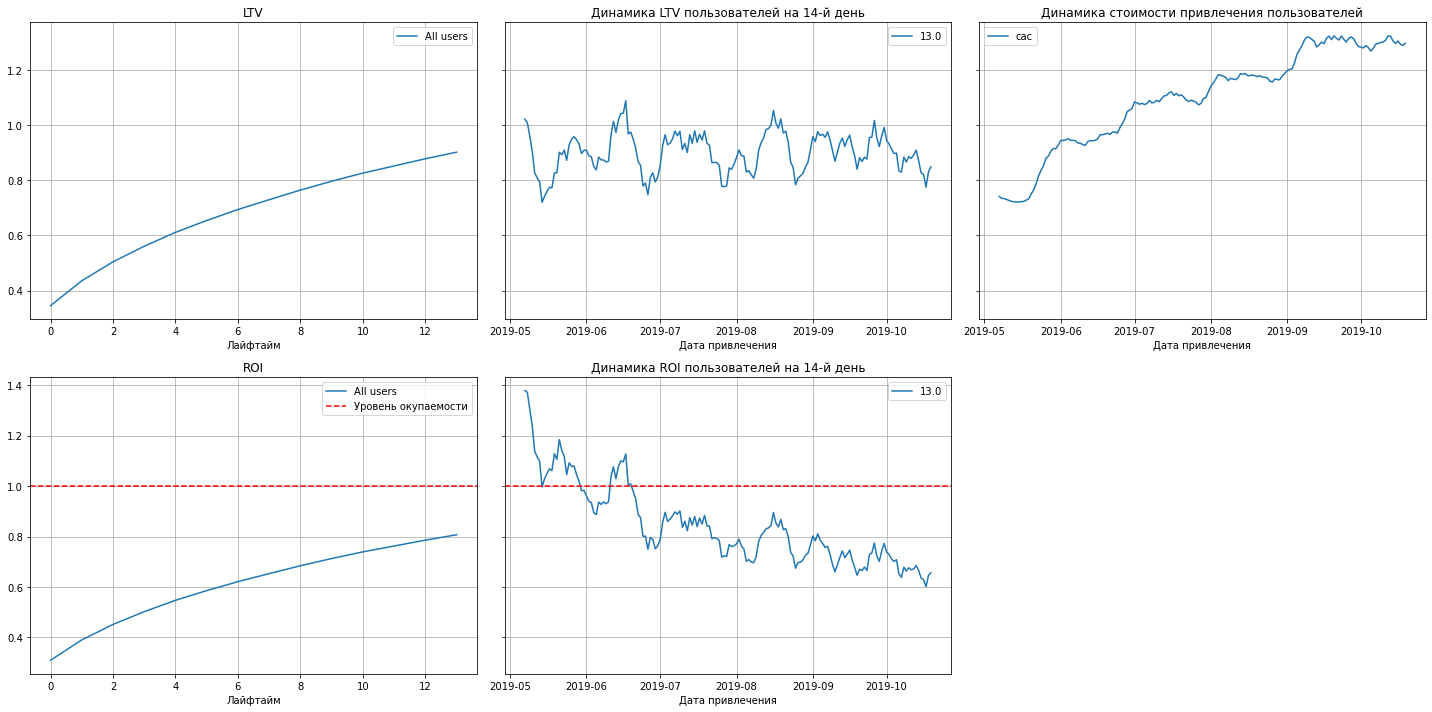

In [40]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(profiles_no, orders, observation_date, horizon_days)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать такие выводы:
- Реклама не окупается. К концу двух недель ROI на уровне 80%
- CAC растет почти все время, причем не плавно, а скачкообразно, то есть рекламные кампании проходят регулярно
- LTV стабилен. Значит, пользователи примерно одинакового качества.

### Окупаемость рекламы с разбивкой по устройствам

Передадим параметру `dimensions` столбец `device`.

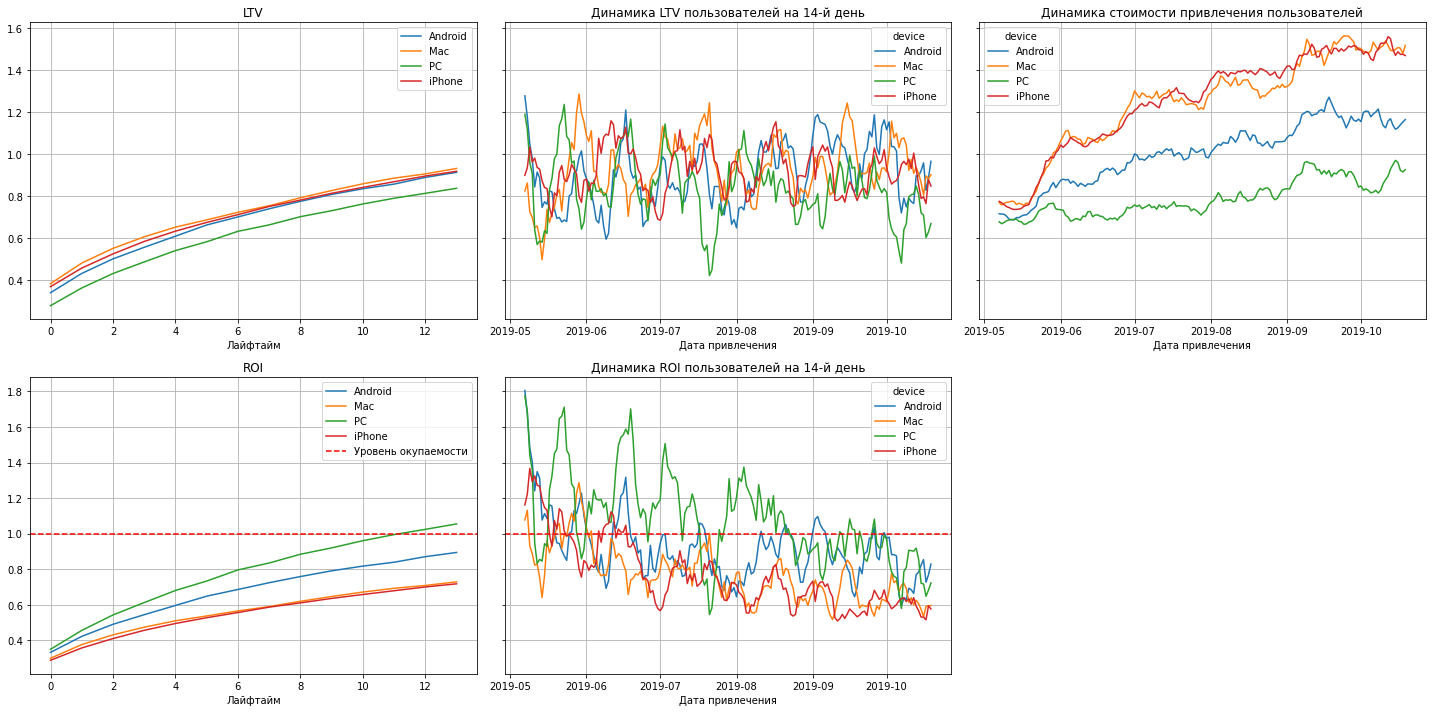

In [41]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
)

По графикам можно сделать такие выводы:
- Реклама не окупается везде, кроме PC.
- CAC растет на всех платформах
- LTV стабилен везде
- хуже всего окупаются владельцы Mac и iPhone

### Окупаемость рекламы с разбивкой по странам

Передадим параметру `dimensions` столбец `region`.

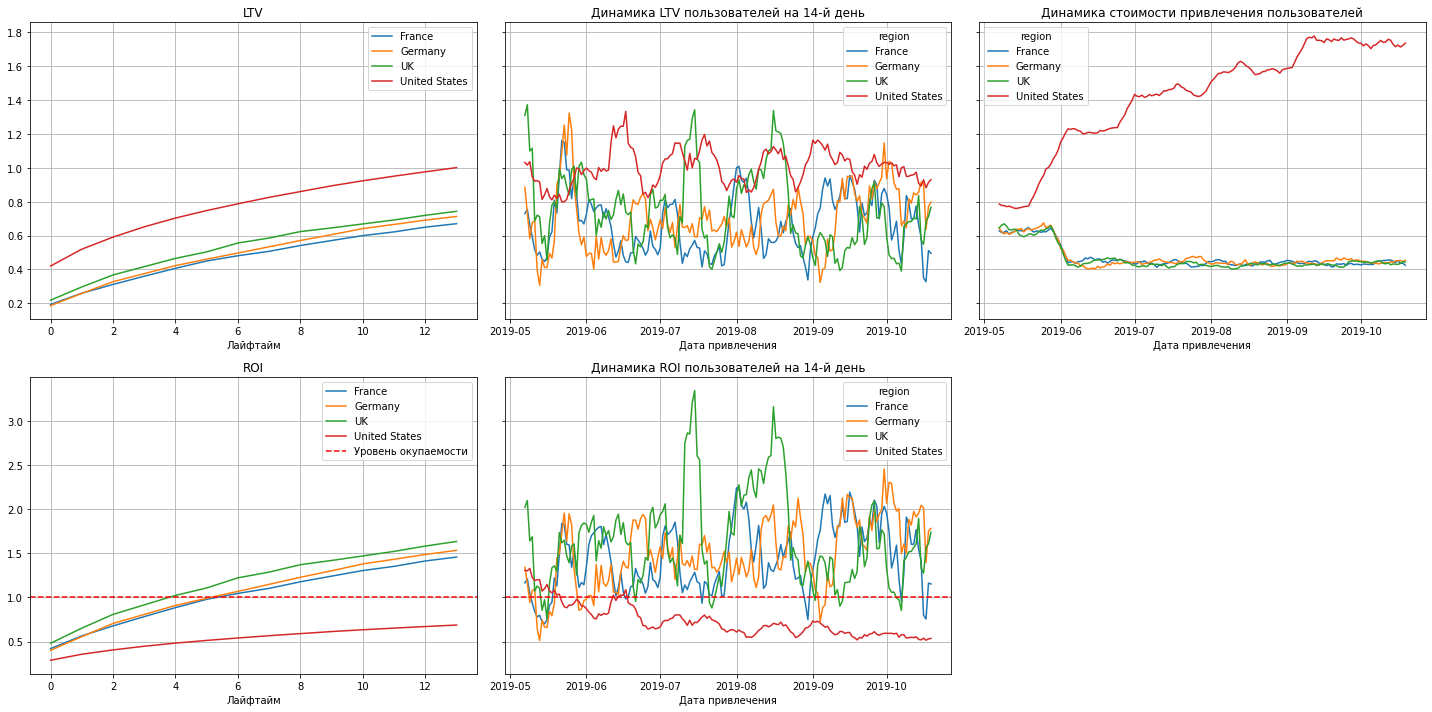

In [42]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
)

По графикам можно сделать такие выводы:
- В Европе реклама окупается уже к 6 дню, в а в США не окупается совсем.
- CAC растет в США, а в Европе резко снижается в июне и дальше держится стабильно низко
- LTV стабилен везде

### Окупаемость рекламы с разбивкой по рекламным каналам

Передадим параметру `dimensions` столбец `channel`.

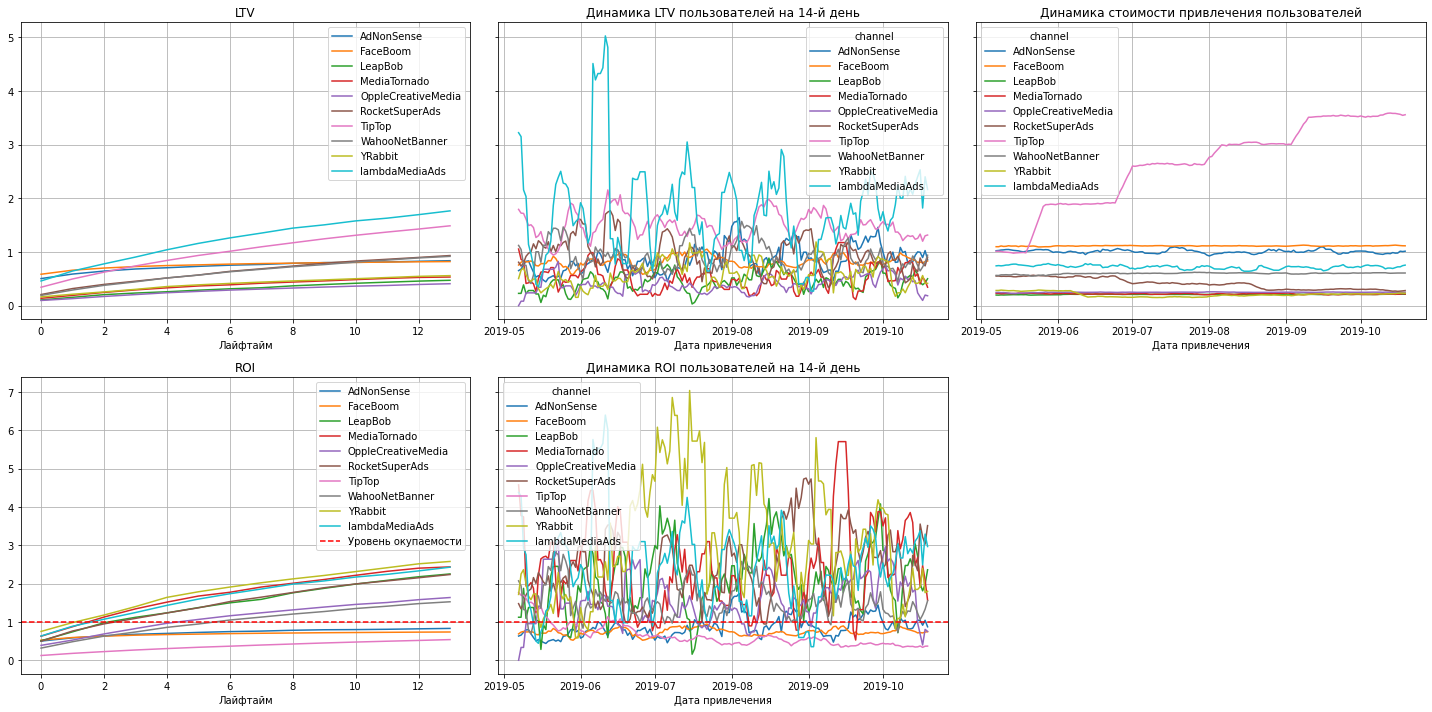

In [43]:
# смотрим окупаемость с разбивкой по каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
)

По графикам можно сделать такие выводы:
- Во всех каналах, кроме TipTop, FaceBoom и AdNonSense реклама окупается. 
- CAC растет в TipTop, а в остальных держится стабильно низко и даже немного падает
- LTV стабилен везде

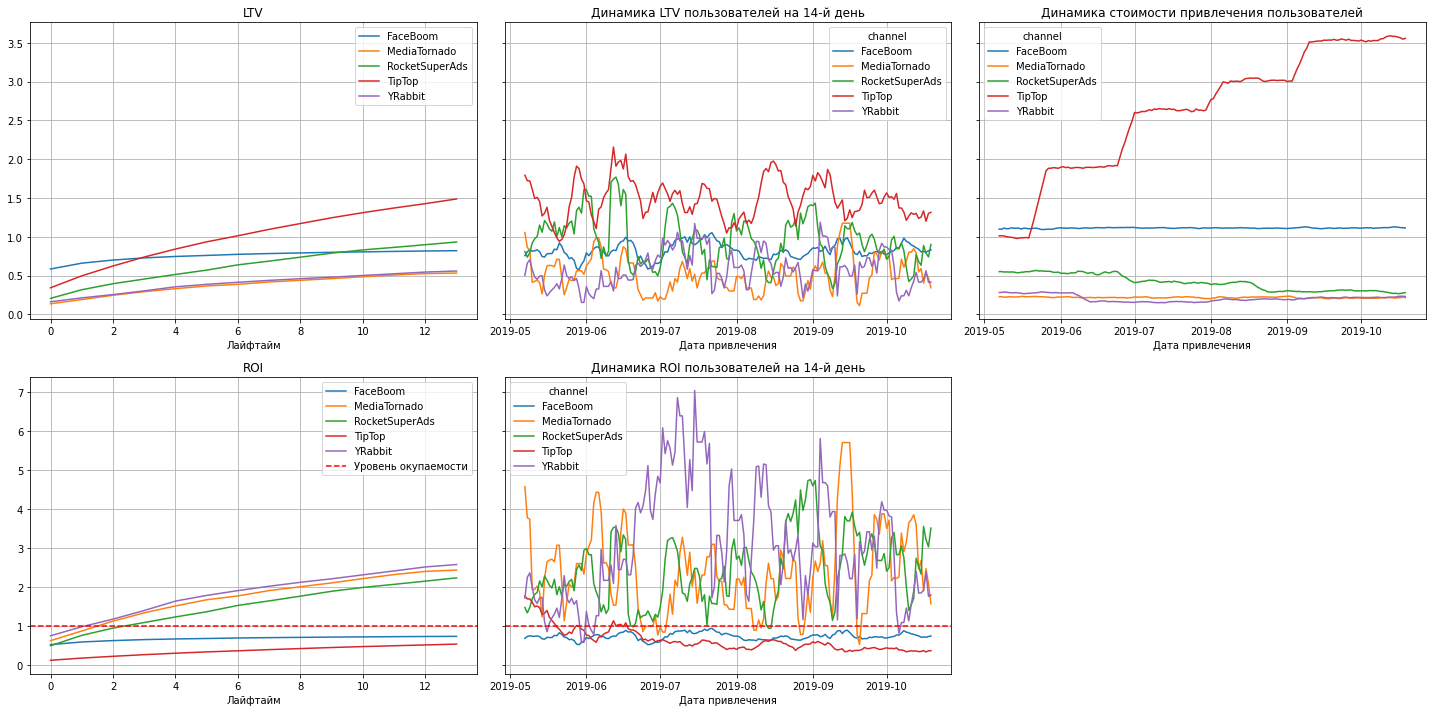

In [44]:
# посмотрим отдельно окупаемость каналов США

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no.query('channel in @usa_channels'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
)

Так в графиках немного меньше шума, но выводы те же:
- CAC TipTop растет скачками от месяца к месяцу, в то время как для остальных платформ стабилен и даже немного снижается
- реклама в TipTop и FaceBoom не окупается вообще, а в остальных каналах - уже к 2-3 дню
- LTV стабилен везде

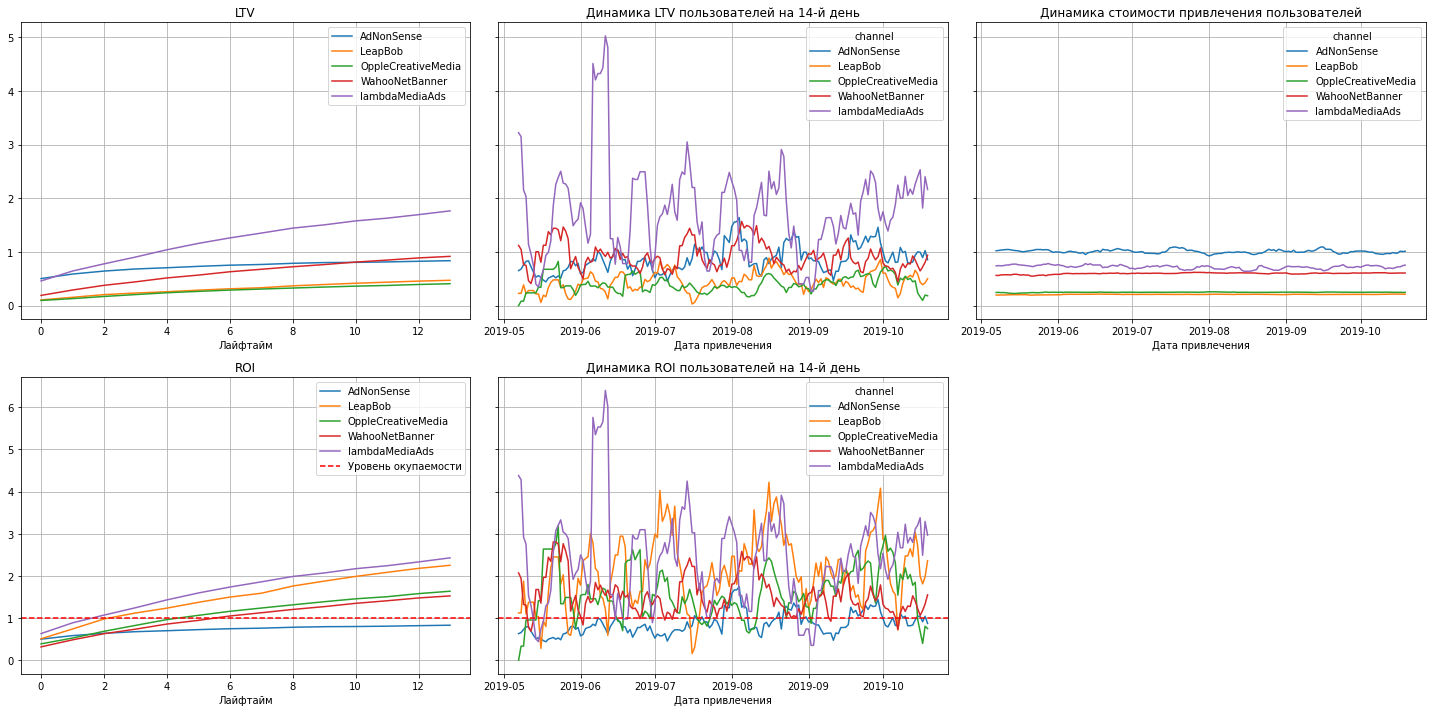

In [45]:
# смотрим окупаемость каналов европы

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no.query('channel in @eu_channels'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=7
)

В Европе не окупается только AdNonSense, но CAC стабильный для всех каналов. 

### Конверсия пользователей

Итак, судя по всему, дыра, куда бесполезно утек рекламный бюджет - TipTop, FaceBoom и  AdNonSense.

Посчитаем и визуализируем конверсию с помощью функций `get_conversion()` и `plot_conversion()`

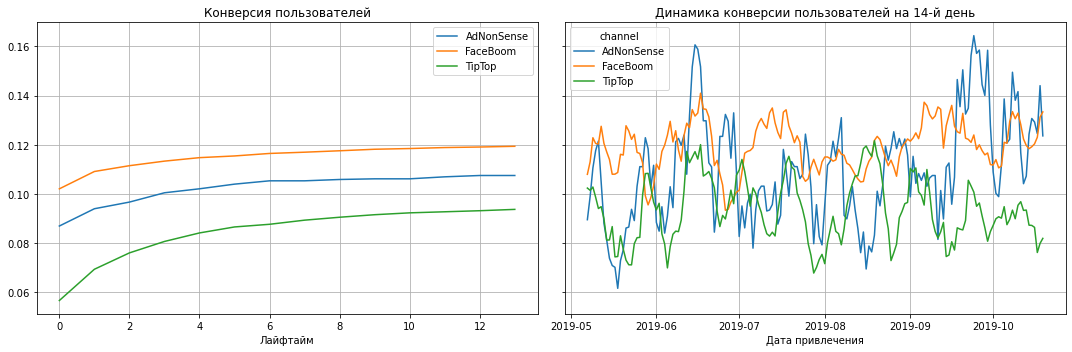

In [46]:
weak_ch = ['TipTop', 'FaceBoom', 'AdNonSense'] 
dimensions = ['channel']

# смотрим конверсию в "плохих" каналах
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_no.query('channel in @weak_ch'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

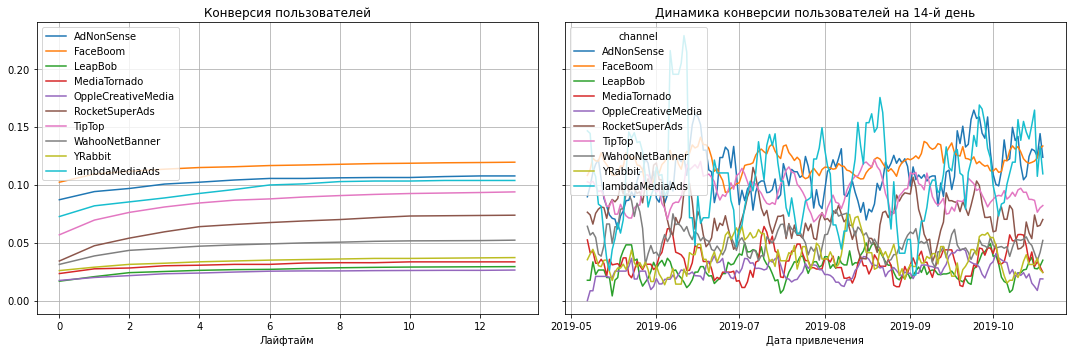

In [47]:
# для сравнения смотрим конверсию с разбивкой по всем каналам
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_no, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Судя по графикам, пользователи из всех сетей конвертируются достаточно хорошо, причем постоянно. 

Вызовем функции `get_retention()` и `plot_retention()`, чтобы рассчитать и отразить на графиках удержание.

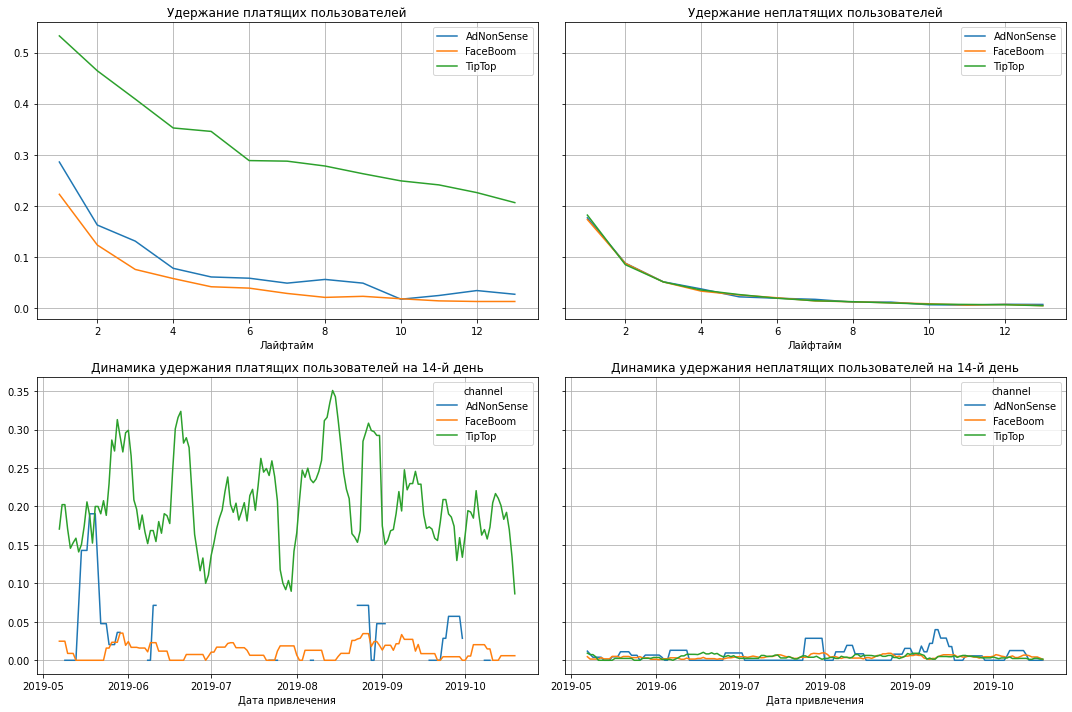

In [48]:
# смотрим удержание в "плохих" каналах
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_no.query('channel in @weak_ch'), visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание неплатящих пользователей из разных каналов, стран, платформ до странного ровное, а удержание платящих очень отличается, быть может, существует какая-то различная мотивация для платящих пользователей в зависимости от сегмента? 

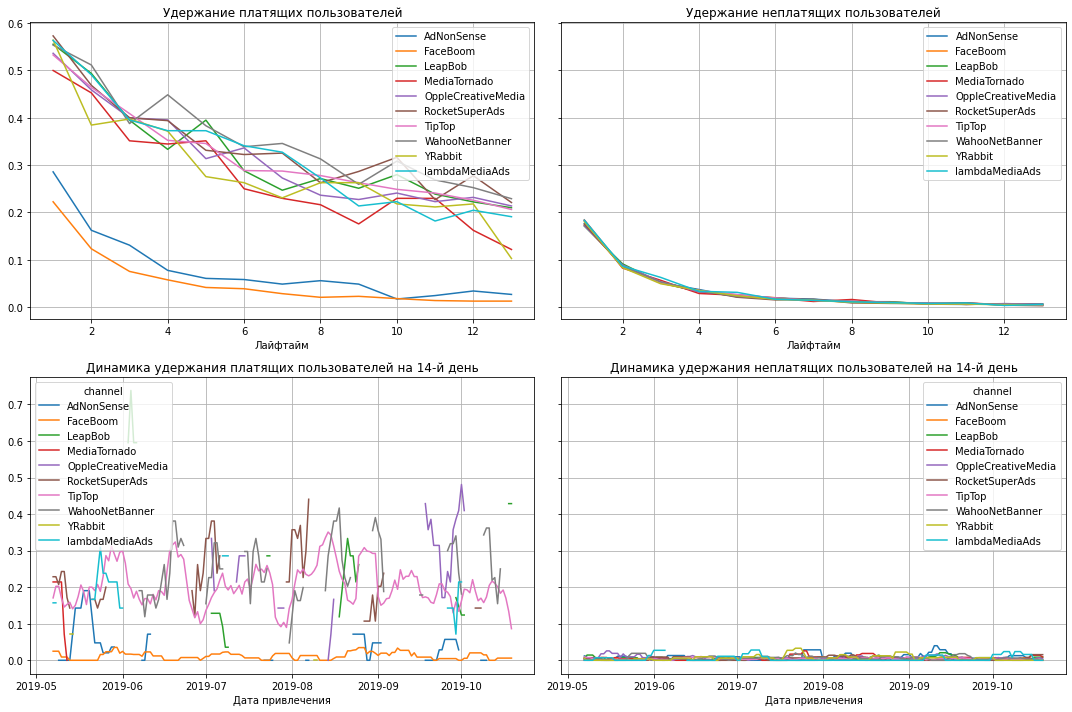

In [49]:
# для сравнения смотрим удержание с разбивкой по всем каналам

dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_no, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Таким образом, при достаточно высокой конверсии, удержание пользователей из FaceBoom и AdNonSense гораздо ниже, чем пользователей из других источников. Возможно, с этих площадок приходит нецелевая аудитория нашего приложения. 

В то же время, удержание пользователей TipTop довольно высокое и конверсия выше среднего. Видимо, это просто очень дорогой канал для рекламы. 

Проверим влияние на конверсию и удержание региона или устройства пользователя. 

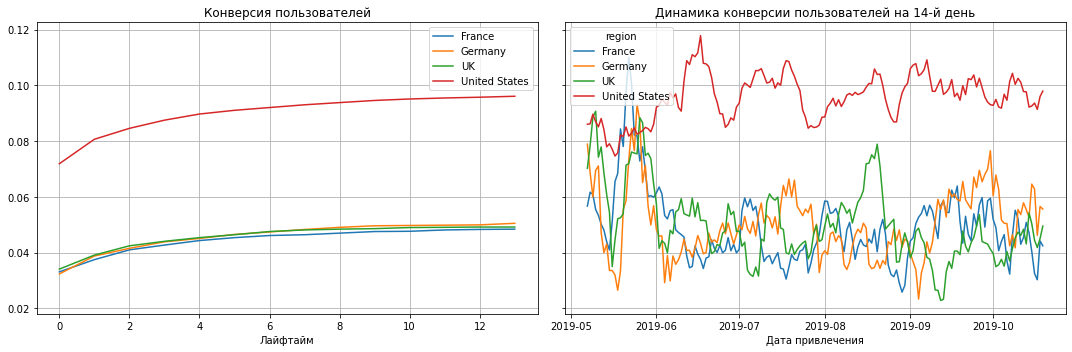

In [50]:
# смотрим конверсию с разбивкой по всем странам
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_no, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

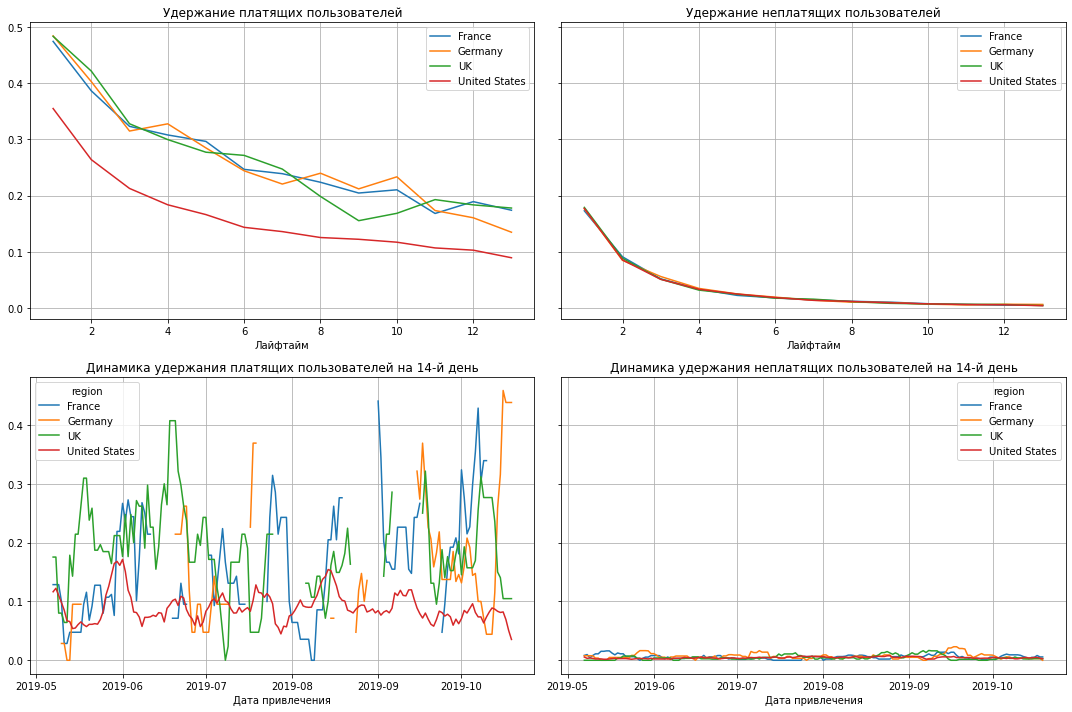

In [51]:
# смотрим удержание с разбивкой по всем странам
dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_no, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Несмотря на огромные рекламные бюджеты и высокую конвверсию в США, удержание платящих пользователей заметно ниже, чем в Европе. 

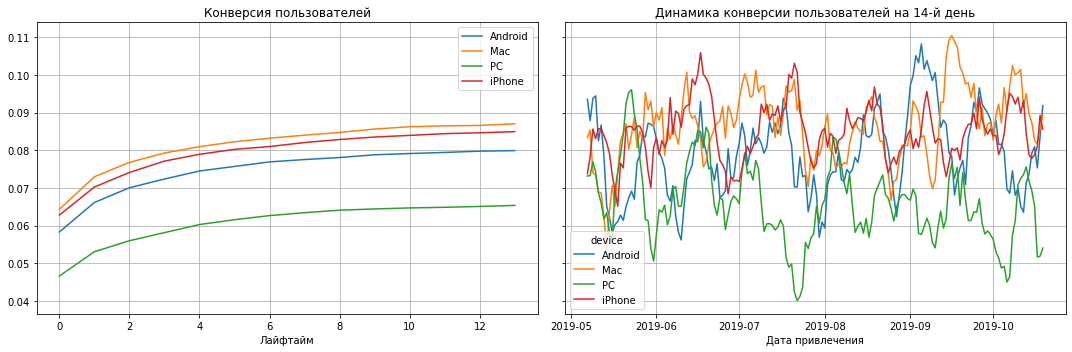

In [52]:
# смотрим конверсию с разбивкой по всем устройствам
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_no, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

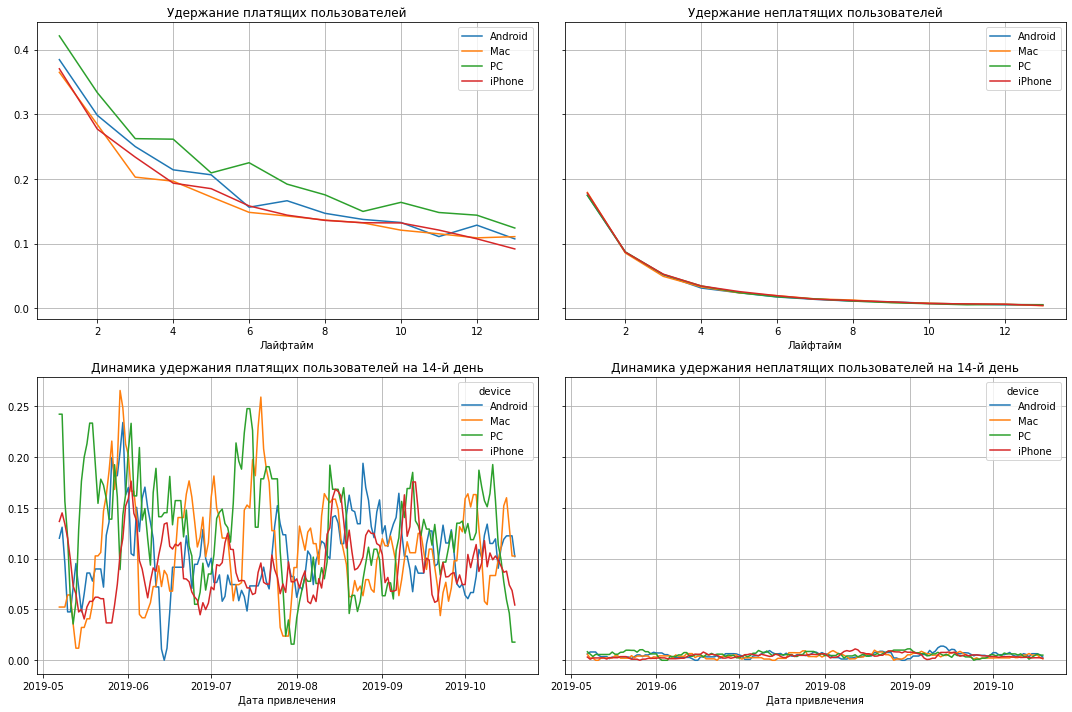

In [53]:
# смотрим удержание с разбивкой по всем устройствам
dimensions = ['device']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_no, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Несмотря на то, что окупаемость рекламы для пользователей PC выше всего, конверсия среди них ниже всех. 

## Выводы

Мы проанализировали активность пользователей и эффективность трат на маркетинг за полгода. 

Аудитория приложения в США в разы выше, чем в странах Европы вместе взятых, и покупки американцы совершают чаще. При этом средняя стоимость привлечения покупателя из Америки выше примерно в полтора раза.

Устройства, с которых пользователи делают покупки, имеют вторичное значение - в США в среднем больше распространены "яблочные" девайсы, в Европе - ПК и телефоны на Андроиде, соответственно, и покупатели распределены так.

Реклама в США окупается в 3 каналах из пяти, в Европе - в 4 из пяти. Каналы, которые не окупаются - TipTop, FaceBoom и AdNonSense.

На площадку TipTop была потрачена почти половина рекламного бюджета приложения, однако при высоком удержании конверсия средняя и окупаемость очень низкая. В среднем каждый покупатель обошелся более чем в 29$. Скорее всего, это очень дорогой канал для рекламы. 

Второй не окупающийся в США канал рекламы - FaceBoom, у которого низкая конверсия и низкое удержание пользователей. Аналогичная ситуация с площадкой AdNonSense в Европе. Скорее всего, с этих каналов приходит не целевая аудитория.

Рекламные бюджеты следует попробовать перераспределить в пользу каналов, окупаемость которых выше: например, lambdaMediaAds	в Европе и RocketSuperAds в США. Оба имеют высокий процент покупателей и низкую стоимость их привлечения. 